# Structure of the code
1. Primodial gas
2. Mass life time relation
3. Stellar yields tables
4. IMF
5. SNIa rate

# Algorithm of the code
1. Essential input

   (1) Star formation history

   (2) Stellar yields tables

   (3) Star formation efficiency

   (4) IMF

2. Initialize primorial gas `GasElement[0]`
3. Calculate the mass locked in zero-age main sequence `StarInitElement[0]` at `Age[0]`
4. Determine the ejecta `EjectElement[0]` of stellar population formed at `Age[0]` during `Age[i]` and `Age[i+1]` (i=0,1,...,N-1)

   (1) For AGB and SNcc, the ejecta is determined by $\mathrm{IMF}\times\mathrm{Yields}$

   (2) For SNIa, the ejecta is determined by the number of SNIa events and SNIa yields
   
5. `GasElement[1]=GasElement[0]+StarInitElement[0]-EjectElement[0]`
6. Likewise, update the rest `GasElement[i] = GasElement[i-1] + StarInitElement[i-1] - EjectElement[i-1]` (i=1,2,...,N-1)

# Some conventions
1. We consider the first 30 elements of the periodic table but the metallicity of the ejecta/wind is defined as $M_{\rm ini}-M_{\rm rem}-M_{\rm H}-M_{\rm He}$
2. The solar abundance tables in number are converted to in mass

   It refers to how much mass of each element per unit mass of hydrogen in the sun.
   The index of one item of `abund_tables` in the `constants.py` start from 1.
   For instance `abund_tables["Default"][2]` is how much mass of helium per unit mass of hydrogen in the `Default` table and 
   `abund_tables["Default"][0]` is set to 0.
3. Both the mass range of the IMF and the stellar yield tables is restricted to be $[0.08,150]~M_{\odot}$
   
   - If the minimum mass $M_{\rm min}$ of the IMF is larger than $0.08~M_{\odot}$, then the IMF in the range $[0.08,M_{\rm min}]~M_{\odot}$ is set to be zero.
   - As is often the case, the $M_{\rm min}$ in the stellar yield tables is larger than $0.08~M_{\odot}$, so the yield in the range $[0.08,M_{\rm min}]~M_{\odot}$ is set to be zero, and the $M_{\rm max}$ in the stellar yield tables is smaller than $150~M_{\odot}$, so the yield in the range $[M_{\rm max},150]~M_{\odot}$ is set to be the same as that at $M_{\rm max}$. As for the $M_{\rm rem}$, it is set to be $M_{\rm ini}$ in the range $[0.08,M_{\rm min}]~M_{\odot}$ and we keep $M_{\rm ini}-M_{\rm rem}$ a constant in the range $[M_{\rm max},150]~M_{\odot}$.
   - The number of sampled mass points in the stellar yield tables are often just a few, so we will interpolate the yield tables to get the yield at any mass in the range $[0.08,150]~M_{\odot}$.

4. About the star formation history file

   - You should input the star formation history in a txt file with just two columns, the first column is the time in `yr` and the second column is the star formation rate in $M_{\odot}~{\rm yr}^{-1}$.
   - You can add as many lines of comments as you want in the header of the txt file, but the comments should be started with `#`, which is the default comment symbol in `np.loadtxt`.
   - The star formation rate in the last line (the last time) won't be used in the calculation of the chemical evolution, so you should set it to be zero.

5. Units

   - The default unit of mass is $M_{\odot}$.
   - The default unit of time is `yr`.

# About the IMF
The IMF in `IMF` class defined in `utils.py` is NORMALIZED to be $\int_{0.08}^{150} \xi(m)dm=1$.
Assuming $M_{\ast, i}$ and $N_{\mathrm{formed}, i}$ are the formed mass and number of stars in ith epoch, respectively:
$$
N_{\mathrm{formed}, i} = \frac{M_{\ast, i}}{\int_{0.08}^{150} m \xi(m)dm}
$$

$N_{\mathrm{formed}, i}$ should be an integer, but we will NOT round it to the nearest integer.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 20, 2024
Last modified on May 20, 2024
@Author: Guan-Fu Liu

To calculate how the abundance evolves with time with variable IMF

Update: 
1. Separate utils.py into IMF.py, primordial_gas.py, SupernovaeIa.py, and MassLifetime.py
2. Interpolate the stellar yields of different initial metallicities.
"""
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '/Users/liuguanfu/Workspace/SAS-21/targets/MRK1216/spex/jupyter/IMF')
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
import h5py
from tqdm import tqdm
import datetime
import re
# The following are the modules defined in the same directory
from MassLifetime import MassLifetime
from IMF import IMF
import utils
import primordial_gas as pg
import constants
%matplotlib widget

In [2]:
###### Set the input and output directories and essential parameters ######
input_dir = "./inputs/"
output_dir = "./outputs/"
SFE = 0.3 # Star formation efficiency
# 0.1 is a typical value, 0.3 is an enhanced value, larger than 0.5 is not physical
if SFE > 0.5:
    print("The star formation efficiency is too high, please check the input value.")
    print("The typical value is 0.1, the enhanced value is 0.3.")
    print("EXIT!")
    sys.exit()

IMF = IMF(IMF_type='Salpeter')
SNIa = utils.SNIa(IMF.imf)
SNIaOn = True  # Whether to consider the SNIa
###### Set the input and output directories and essential parameters ######

###### Load the star formation history ######
SFH = { }
# SFH['File'] = f"{input_dir}/SFH-1delta.txt"
# SFH['Age'] = np.loadtxt(SFH['File'])[:, 0]
# SFH['SFR'] = np.loadtxt(SFH['File'])[:, 1]

SFH['File'] = f"{input_dir}/SFH.h5"
with h5py.File(SFH['File'], 'r') as f:
    SFH['Age'] = f['SFH/1Square'][...][:, 0]
    SFH['SFR'] = f['SFH/1Square'][...][:, 1]

SFH['Mstar'] = np.zeros(len(SFH['Age']))
SFH['TimeBin'] = np.zeros(len(SFH['Age']))
SFH['TimeBin'][:-1] = np.diff(SFH['Age'])  # The time bin of each time, the time bin of the last time is set to ZERO.
SFH['Mstar'][:-1] = SFH['SFR'][:-1] * np.diff(SFH['Age'])  # The mass of stars formed in each time bin
# We do not consider the mass of stars formed in the last time!
SFH['Mtot'] = np.sum(SFH['Mstar'])  # The total mass of stars formed.
if np.diff(SFH['Age'])[0] < 0:
    print("The age should be in ascending order!")
    print("EXIT!")
    sys.exit()
###### Load the star formation history ######

###### Load the yields table ######
yield_files = {
                "AGB+SNcc": "./inputs/NuPyCEE/portinari98_gce_in_igimf/yields1.h5",
                # "AGB+SNcc": "./inputs/K10_N13_S16/agb_and_massive_stars_K10_N13/yields1.h5",
                "SNIa": "./inputs/SNIa_TNH93/yields1.h5",
               }
files = {key: h5py.File(value, 'r') for key, value in yield_files.items()}
groups = {key: list(files[key].keys()) for key in files.keys()}  # The available metallicity values in yield table
# The available metallicity values in yield table
Zyield = {key: np.array([float(group.split("=")[1]) for group in groups[key]]) for key in groups.keys()}
ElemNotice = ["H", "He", "C", "N", "O", "Ca", "Ne", "Si", "Mg", "S", "Fe", "Other"] # The elements we are interested in
# They should appear in the yield table from AGB+SNcc.
# It should contain H, He and Other.
# The finally selected elements are the intersection of ElemNotice and the elements avaliable in the yield table.
# You may as well not to notice too many elements, which will speed down the calculation.
dfs = { }
ElemIntersect = { }
for key in files.keys():
    dfs[key] = { }
    ElemIntersect[key] = { }
    for group in groups[key]:
        if key == "SNIa":
            dfs[key][group] = pd.DataFrame(files[key][group]['Original'][...])
        else:
            dfs[key][group] = pd.DataFrame(files[key][group]['Interpolated'][...])
        dfs[key][group].loc[:, 'M'] = dfs[key][group].loc[:, 'M'].astype(str)
        dfs[key][group].set_index('M', inplace=True)
        index = dfs[key][group].index
        index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
        # Add the mass of the elements not in ElemNotice to the "Other" element
        if "Other" in dfs[key][group].index:
            dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
        else:
            dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
        ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))

for key in files.keys():
    for group in groups[key]:
        if len(set(ElemNotice)-set(ElemIntersect[key][group]))>0:
            print("The elements you notice but not available in the yield table of %s, %s are" %\
                 (key, group), set(ElemNotice)-set(ElemIntersect[key][group]))

###### Load the yields table ######

The elements you notice but not available in the yield table of SNIa, Z=0.02 are {'H', 'N', 'C', 'Ca', 'He'}


In [3]:
###### Read the mass lifetime relation ######
mass_lifetime_file = "./inputs/NuPyCEE/isotope_yield_table_portinari98_marigo01_gce_totalyields/yields1.h5"
file = h5py.File(mass_lifetime_file, "r")
lifetime = { }
for key in file.keys():
    lifetime[key] = { }
    lifetime[key]['Mini'] = file[key]['MassLifetime'][:,0].astype(float)
    lifetime[key]['lifetime'] = file[key]['MassLifetime'][:,1].astype(float)

mass_lifetime = MassLifetime(lifetime=lifetime)
file.close()
###### Read the mass lifetime relation ######

In [4]:
###### Determine the primordial gas ######
mass = SFH['Mtot'] / SFE  # The total mass of the primordial gas in the unit of Msun
solar_set = "Default"  # The solar abundance set
pr_gas = pg.Primordial_gas(mass=mass, Z_0=0).add_metals(abund_table=constants.abund_tables[solar_set])
###### Determine the primordial gas ######

###### Initialize other essential variables ######
YieldsTable = np.empty((len(SFH['Age']), 2), dtype=object)
GasElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
ZGas = np.zeros(len(SFH['Age']), dtype=np.float64)
Nstar = np.zeros(len(SFH['Age']), dtype=np.float64)
StarInitElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
EjectElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
SNIaNum = np.zeros(len(SFH['Age']), dtype=np.float64)
###### Initialize other essential variables ######

###### Step 0: Initialize the first time, the primordial gas ######
# The definition of the following variables is can be found in the excel file Variables.xlsx
GasElement[0] = pr_gas['Gas']
ZGas[0] = GasElement[0, 3:].sum() / GasElement.sum()  # The metallicity of the primordial gas
StarInitElement[0] = SFH['Mstar'][0] * (GasElement[0]/GasElement[0].sum())
Nstar[0] = SFH['Mstar'][0] / quad(lambda m: m*IMF.imf(m), constants.Mstar_min, constants.Mstar_max, full_output=1)[0]
print("Step 0: Initialize the first time, the primordial gas")
dEjectElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
dSNIaNum = np.zeros(len(SFH['Age']), dtype=np.float64)
# mass boundary of each time bin
mass_bounds = np.array([constants.Mstar_max]+
                            [mass_lifetime.lifetime_to_mass(SFH['TimeBin'][0:k+1].sum(), ZGas[0]) \
                             for k in range(0, len(SFH['Age'])-1)])
for j in tqdm(range(0, len(SFH['Age'])-1)):
    # Get the closest metallicity in the yield table
    # Interpolate the stellar yields of different initial metallicities
    Zindex = { }
    for key in Zyield.keys():
        Zindex[key] = { }
        if ZGas[0] <= Zyield[key].min():
            # The metallicity of the gas is no more than the lowest metallicity in the yield table
            Zindex[key]['low'] = Zyield[key].argmin()
            Zindex[key]['high'] = Zindex[key]['low']
        elif ZGas[0] >= Zyield[key].max():
            # The metallicity of the gas is no less than the highest metallicity in the yield table
            Zindex[key]['low'] = Zyield[key].argmax()
            Zindex[key]['high'] = Zindex[key]['low']
        else:
            Zindex[key]['high'] = np.where(Zyield[key]==Zyield[key][Zyield[key]>ZGas[0]].min(),)[0][0]
            Zindex[key]['low']  = np.where(Zyield[key]==Zyield[key][Zyield[key]<ZGas[0]].max(),)[0][0]
    # Calculate the mass of ejceta from AGB and SNcc happened in this time bin
    x_low = dfs["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]["low"]]].columns.to_numpy().astype(np.float64)
    x_high = dfs["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]["high"]]].columns.to_numpy().astype(np.float64)
    for elem in ElemIntersect["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']]]:
        Z_low = Zyield["AGB+SNcc"][Zindex["AGB+SNcc"]['low']]
        Z_high = Zyield["AGB+SNcc"][Zindex["AGB+SNcc"]['high']]
        y_low = dfs["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']]].loc[elem].to_numpy().astype(np.float64)
        y_high = dfs["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]['high']]].loc[elem].to_numpy().astype(np.float64)
        # Interpolate the stellar yields of different initial metallicities
        interp_low = interpolate.interp1d(x_low, y_low, kind='linear', fill_value='extrapolate')
        interp_high = interpolate.interp1d(x_high, y_high, kind='linear', fill_value='extrapolate')
        ElemIndex = constants.elem_names.index(elem)
        if Z_low == Z_high:
            dEjectElement[j, ElemIndex] = Nstar[0]*(quad(lambda m: 
                                         IMF.imf(m)*interp_low(m), 
                                         mass_bounds[j+1], mass_bounds[j],
                                         epsrel=1e-5, limit=80, full_output=1)[0])
        else:
            dEjectElement[j, ElemIndex] = Nstar[0]*(quad(lambda m: 
                                         IMF.imf(m)*(interp_low(m)+\
                                                     (interp_high(m)-interp_low(m))/(Z_high-Z_low)*(ZGas[0]-Z_low)), 
                                                     mass_bounds[j+1], mass_bounds[j],
                                                     epsrel=1e-5, limit=80, full_output=1)[0])
    # Calculate the number of SNIa events happened in this time bin, proginitor stars formed at Age[0]
    dSNIaNum[j] = SNIa.number(SFH['Mstar'][0], SFH['Age'][j]-SFH['Age'][0], SFH['Age'][j+1]-SFH['Age'][0])

# The ejected mass of elements from AGB+SNcc and SNIa, proginitor stars formed at Age[0]
EjectElement += dEjectElement
# The ejected mass of elements from SNIa, proginitor stars formed at Age[0]
if SNIaOn:
    for elem in ElemIntersect["SNIa"][groups["SNIa"][Zindex["SNIa"]['low']]]:
        ElemIndex = constants.elem_names.index(elem)
        Z_low = Zyield["SNIa"][Zindex["SNIa"]['low']]
        Z_high = Zyield["SNIa"][Zindex["SNIa"]['high']]
        y_low = dfs["SNIa"][groups["SNIa"][Zindex["SNIa"]['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
        y_high = dfs["SNIa"][groups["SNIa"][Zindex["SNIa"]['high']]].loc[elem, groups['SNIa'][Zindex['SNIa']['high']]]
        # Interpolate the stellar yields of different initial metallicities
        if y_low == y_high:
            y = y_low
        else:
            y = y_low + (y_high-y_low)/(Z_high-Z_low)*(ZGas[0]-Z_low)
        EjectElement[:, ElemIndex] += dSNIaNum * y

SNIaNum += dSNIaNum
YieldsTable[0,0] = "AGB+SNcc: %s, SNIa: %s" % (groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']],
                                               groups["SNIa"][Zindex["SNIa"]['low']])
YieldsTable[0,1] = "AGB+SNcc: %s, SNIa: %s" % (groups["AGB+SNcc"][Zindex["AGB+SNcc"]['high']],
                                               groups["SNIa"][Zindex["SNIa"]['high']])
###### Step 0: Initialize the first time, the primordial gas ######

###### Step 1: Calculate the remaining ages ######
print("Step 1: Calculate the remaining ages")
for i in tqdm(range(1, len(SFH['Age'])-1)):
    GasElement[i] = GasElement[i-1] + EjectElement[i-1] - StarInitElement[i-1]
    ZGas[i] = GasElement[i, 3:].sum() / GasElement[i].sum()
    dEjectElement = np.zeros((len(SFH['Age']), len(constants.abund_tables[solar_set])), dtype=np.float64)
    dSNIaNum = np.zeros(len(SFH['Age']), dtype=np.float64)
    if SFH['Mstar'][i] > 0:
        StarInitElement[i] = SFH['Mstar'][i] * (GasElement[i]/GasElement[i].sum())
        Nstar[i] = SFH['Mstar'][i] / quad(lambda m: m*IMF.imf(m), constants.Mstar_min, constants.Mstar_max, full_output=1)[0]
        # mass boundary of each time bin
        mass_bounds = np.array([constants.Mstar_max]+
                               [mass_lifetime.lifetime_to_mass(SFH['TimeBin'][i:k+1].sum(), ZGas[i])\
                                 for k in range(i, len(SFH['Age'])-1)])
        for j in range(i, len(SFH['Age'])-1):
            # Interpolate the stellar yields of different initial metallicities
            Zindex = { }
            for key in Zyield.keys():
                Zindex[key] = { }
                if ZGas[i] <= Zyield[key].min():
                    # The metallicity of the gas is no more than the lowest metallicity in the yield table
                    Zindex[key]['low'] = Zyield[key].argmin()
                    Zindex[key]['high'] = Zindex[key]['low']
                elif ZGas[i] >= Zyield[key].max():
                    # The metallicity of the gas is no less than the highest metallicity in the yield table
                    Zindex[key]['low'] = Zyield[key].argmax()
                    Zindex[key]['high'] = Zindex[key]['low']
                else:
                    Zindex[key]['high'] = np.where(Zyield[key]==Zyield[key][Zyield[key]>ZGas[i]].min(),)[0][0]
                    Zindex[key]['low']  = np.where(Zyield[key]==Zyield[key][Zyield[key]<ZGas[i]].max(),)[0][0]
            
            # Calculate the mass of ejceta from AGB and SNcc happened in this time bin
            x_low = dfs["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]["low"]]].columns.to_numpy().astype(np.float64)
            x_high = dfs["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]["high"]]].columns.to_numpy().astype(np.float64)
            for elem in ElemIntersect["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']]]:
                Z_low = Zyield["AGB+SNcc"][Zindex["AGB+SNcc"]['low']]
                Z_high = Zyield["AGB+SNcc"][Zindex["AGB+SNcc"]['high']]
                y_low = dfs["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']]].loc[elem].to_numpy().astype(np.float64)
                y_high = dfs["AGB+SNcc"][groups["AGB+SNcc"][Zindex["AGB+SNcc"]['high']]].loc[elem].to_numpy().astype(np.float64)
                # Interpolate the stellar yields of different initial metallicities
                interp_low = interpolate.interp1d(x_low, y_low, kind='linear', fill_value='extrapolate')
                interp_high = interpolate.interp1d(x_high, y_high, kind='linear', fill_value='extrapolate')
                ElemIndex = constants.elem_names.index(elem)
                if Z_low == Z_high:
                    dEjectElement[j, ElemIndex] = Nstar[0]*(quad(lambda m: 
                                                IMF.imf(m)*interp_low(m), 
                                                mass_bounds[j+1-i], mass_bounds[j-i],
                                                epsrel=1e-5, limit=80, full_output=1)[0])
                else:
                    dEjectElement[j, ElemIndex] = Nstar[0]*(quad(lambda m: 
                                                IMF.imf(m)*(interp_low(m)+\
                                                            (interp_high(m)-interp_low(m))/(Z_high-Z_low)*(ZGas[i]-Z_low)), 
                                                            mass_bounds[j+1-i], mass_bounds[j-i],
                                                            epsrel=1e-5, limit=80, full_output=1)[0])
            # Calculate the number of SNIa events happened in this time bin, proginitor stars formed at Age[i]
            dSNIaNum[j] = SNIa.number(SFH['Mstar'][0], SFH['Age'][j]-SFH['Age'][i], SFH['Age'][j+1]-SFH['Age'][i])
        # The ejected mass of elements from AGB+SNcc and SNIa, proginitor stars formed at Age[i]
        EjectElement += dEjectElement
        # The ejected mass of elements from SNIa, proginitor stars formed at Age[i]
        if SNIaOn:
            for elem in ElemIntersect["SNIa"][groups["SNIa"][Zindex["SNIa"]['low']]]:
                ElemIndex = constants.elem_names.index(elem)
                Z_low = Zyield["SNIa"][Zindex["SNIa"]['low']]
                Z_high = Zyield["SNIa"][Zindex["SNIa"]['high']]
                y_low = dfs["SNIa"][groups["SNIa"][Zindex["SNIa"]['low']]].loc[elem, groups['SNIa'][Zindex['SNIa']['low']]]
                y_high = dfs["SNIa"][groups["SNIa"][Zindex["SNIa"]['high']]].loc[elem, groups['SNIa'][Zindex['SNIa']['high']]]
                # Interpolate the stellar yields of different initial metallicities
                if y_low == y_high:
                    y = y_low
                else:
                    y = y_low + (y_high-y_low)/(Z_high-Z_low)*(ZGas[i]-Z_low)
                EjectElement[:, ElemIndex] += dSNIaNum * y
        SNIaNum += dSNIaNum
        YieldsTable[i,0] = "AGB+SNcc: %s, SNIa: %s" % (groups["AGB+SNcc"][Zindex["AGB+SNcc"]['low']],
                                                       groups["SNIa"][Zindex["SNIa"]['low']])
        YieldsTable[i,1] = "AGB+SNcc: %s, SNIa: %s" % (groups["AGB+SNcc"][Zindex["AGB+SNcc"]['high']],
                                                       groups["SNIa"][Zindex["SNIa"]['high']])
    else:
        # If no star formation between this age and the next age, 
        # there is no ejecta from the stars formed in this time interval.
        YieldsTable[i,0] = "No Star Formation"
        YieldsTable[i,1] = "No Star Formation"
        continue

# The last age
GasElement[len(SFH['Age'])-1] = GasElement[len(SFH['Age'])-2] + \
    EjectElement[len(SFH['Age'])-2] - StarInitElement[len(SFH['Age'])-2]
ZGas[len(SFH['Age'])-1] = GasElement[len(SFH['Age'])-1, 3:].sum() / GasElement[len(SFH['Age'])-1].sum()
YieldsTable[len(SFH['Age'])-1,0] = "No Star Formation"
YieldsTable[len(SFH['Age'])-1,1] = "No Star Formation"
###### Step 1: Calculate the remaining ages ######

for file in files.values():
    file.close()

Step 0: Initialize the first time, the primordial gas


100%|██████████| 1363/1363 [00:04<00:00, 334.03it/s]


Step 1: Calculate the remaining ages


100%|██████████| 1362/1362 [10:46<00:00,  2.11it/s]


# Add the IMF information in the output file!!!!

In [5]:
####### Step 2: Save the results #######
# Get the current date and time
current_time = datetime.datetime.now()
# Format the date and time as "YYYY-MM-DD-HH-MM"
formatted_time = current_time.strftime('%Y-%m-%d-%H-%M')
with h5py.File(f"{output_dir}/%s.h5"%formatted_time, 'w') as f:

    f.attrs["AGB+SNcc yield file"] = yield_files["AGB+SNcc"]
    f.attrs["SNIa yield file"] = yield_files["SNIa"]
    f.attrs["SFH file"] = SFH['File']
    f.attrs['Concerned Elements'] = ElemNotice
    if SNIaOn:
        f.attrs["SNIaOn"] = "Yes"
    else:
        f.attrs["SNIaOn"] = "No"
    f.create_group("Star")
    f["Star"].attrs["Comments"] = "Mass in Msun, Time in Gyr, SFR in Msun/yr, Mtot in Msun"
    f["Star"].attrs["SFE"] = SFE
    f["Star"].attrs["Mtot"] = SFH["Mtot"]
    f.create_dataset("Star/StarInitElement", data=StarInitElement)
    f.create_dataset("Star/SNIaNum", data=SNIaNum)
    f.create_dataset("Star/Age", data=SFH['Age'])
    f.create_dataset("Star/SFR", data=SFH['SFR'])
    f.create_dataset("Star/Mstar", data=SFH['Mstar'])
    f.create_dataset("Star/TimeBin", data=SFH['TimeBin'])
    f.create_dataset("Star/Nstar", data=Nstar)

    f.create_group("Gas")
    f.create_dataset("Gas/GasElement", data=GasElement)
    f.create_dataset("Gas/ZGas", data=ZGas)
    f.create_dataset("Gas/EjectElement", data=EjectElement)
    f.create_dataset("Gas/YieldsTable", data=np.array(YieldsTable, dtype='S'))

####### Step 2: Save the results #######

In [6]:
print(formatted_time, SNIaOn)

2024-05-20-18-26 True


# Simple plot to check

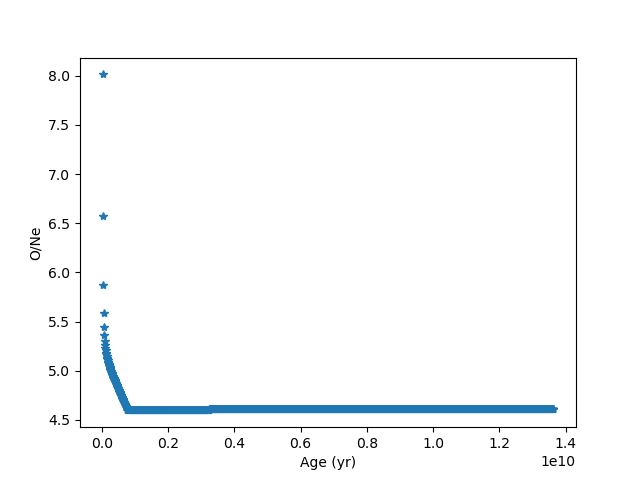

In [7]:
# Detailed model
O2Ne = { }
O2Ne[solar_set] = constants.abund_tables[solar_set][constants.elem_names.index("O")]/\
    constants.abund_tables[solar_set][constants.elem_names.index("Ne")]
mask = GasElement[:, constants.elem_names.index("Ne")]>0
y = GasElement[mask, constants.elem_names.index("O")]/GasElement[mask, constants.elem_names.index("Ne")]/O2Ne[solar_set]
fig, ax = plt.subplots()
ax.plot(SFH['Age'][mask], y, '*', label='O/Ne')
ax.set_xlabel('Age (yr)')
ax.set_ylabel('O/Ne')
plt.show()

In [8]:
y-y[0]+7.99820895

array([7.99820895, 6.56174385, 5.851267  , ..., 4.59649399, 4.59649718,
       4.59649846])

In [9]:
# From the yield table, toy model
Zini = re.search(r"AGB\+SNcc: (.*?),", YieldsTable[1]).group(1)
x = dfs['AGB+SNcc'][Zini].columns.to_numpy().astype(np.float64)
y1 = dfs['AGB+SNcc'][Zini].loc['O'].to_numpy().astype(np.float64)
y2 = dfs['AGB+SNcc'][Zini].loc['Ne'].to_numpy().astype(np.float64)
interp1 = interpolate.interp1d(x, y1, kind='linear', fill_value='extrapolate')
interp2 = interpolate.interp1d(x, y2, kind='linear', fill_value='extrapolate')
mass_bound = mass_lifetime.lifetime_to_mass(1.3e10, 0.04)
O2Ne = { }
O2Ne[solar_set] = constants.abund_tables[solar_set][constants.elem_names.index("O")]/\
    constants.abund_tables[solar_set][constants.elem_names.index("Ne")]


def PowerLaw(m, Gamma, interp):
    return m**(-Gamma-1)*interp(m)


Gammas = np.linspace(1.349, 1.351, 100)
Oxygen = np.array([quad(PowerLaw, mass_bound, constants.Mstar_max, args=(Gamma, interp1), full_output=1)[0] \
                   for Gamma in Gammas])
Neon = np.array([quad(PowerLaw, mass_bound, constants.Mstar_max, args=(Gamma, interp2), full_output=1)[0] \
                 for Gamma in Gammas])

fig, ax = plt.subplots()
ax.plot(Gammas, Oxygen/Neon/(O2Ne[solar_set]), label='O/Ne')
ax.set_xlabel('Gamma')
ax.set_ylabel('O/Ne')
fig.tight_layout()
plt.show()

TypeError: cannot use a string pattern on a bytes-like object

In [ ]:
mass_lifetime.lifetime_to_mass(1.3e10, 0.04)

In [ ]:
Zini = re.search(r"AGB\+SNcc: (.*?),", YieldsTable[0]).group(1)
x = dfs['AGB+SNcc'][Zini].columns.to_numpy().astype(np.float64)
y1 = dfs['AGB+SNcc'][Zini].loc['O'].to_numpy().astype(np.float64)
y2 = dfs['AGB+SNcc'][Zini].loc['Ne'].to_numpy().astype(np.float64)
fig, ax = plt.subplots()
ax.plot(x, y1/y2, '*')
ax.set_xlabel('Mass')
ax.set_ylabel('O/Ne')

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 8))
axes[0].plot(SFH['Age'], SNIaNum, '-.')
axes[0].set_ylabel('Cumulative SNIa number')
axes[1].plot(SFH['Age'], SFH['SFR'], '--')
axes[1].set_xlabel('Age (yr)')
axes[1].set_ylabel(r'SFR ($M_\odot$/yr)')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 8))
axes[0].plot(SFH['Age'], SNIaNum.cumsum(), '-.')
axes[0].set_ylabel('Cumulative SNIa number')
axes[1].plot(SFH['Age'], SFH['SFR'], '--')
axes[1].set_xlabel('Age (yr)')
axes[1].set_ylabel(r'SFR ($M_\odot$/yr)')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 8))
axes[0].plot(SFH['Age'], EjectElement[:, constants.elem_names.index('O')].cumsum(), '-')
axes[0].set_ylabel(r'Cumulative mass of ejected O ($M_{\odot}$')
axes[1].plot(SFH['Age'], SFH['SFR'], '--')
axes[1].set_xlabel('Age (yr)')
axes[1].set_ylabel(r'SFR ($M_\odot$/yr)')
plt.show()

In [ ]:
def GetZi2Zj(GasElement, Zi, Zj, solar_set, fill_value=None):
    """
    To get the ratio of the element j to the element i in the solar unit.

    If the mass of the element j at some ages are zero, the ratio of the element j to the element i is set to fill_value.

    Parameters
    ----------
    GasElement : numpy array
        The mass of elements. The shape of GasElement should be (N, 32). Here N is them number of ages, 32 is the number of elements
        (the first and the last elemen are empty and "others", should not be used).
    Zi : str
        The element i. It should be in the list of constants.elem_names, namely, from H to Zn (Z=1, 2, 3, ..., 30).
    Zj : str
        The element j. It should be in the list of constants.elem_names, namely, from H to Zn (Z=1, 2, 3, ..., 30).
    solar_set : str
        The solar abundance set. It should be in the list of constants.abund_tables.keys().
    fill_value : float or None, optional
        The value to fill the ratio of the element j to the element i if the mass of the element j or the element i is zero.
        If it is None, mask the ages where the mass of the element j is zero, which will change the shape of the output.
        If it is a float, it should be a positive number.

    Returns
    -------
    Zi2Zj: dict
        The ratio of the element j to the element i in the solar unit.
        Zi2Zj['%s/%s'%(Zi, Zj)] is the ratio of the element j to the element i, in the solar unit.
        Zi2Zj['[%s/%s]'%(Zi, Zj)] is log10(Zi2Zj['%s/%s'%(Zi, Zj)]).
        Zi2Zj['%s-mask'%Zj] is the mask of the ages where BOTH of the mass of the element j and i is POSITIVE.
    """
    if Zi not in constants.elem_names or Zj not in constants.elem_names:
        print("The element should be in the list of constants.elem_names, which is ", constants.elem_names)
        return None
    if solar_set not in constants.abund_tables.keys():
        print("The solar abundance set should be in the list of constants.abund_tables.keys(), which is ",
               constants.abund_tables.keys())
        return None
    Zi2Zj_solar = constants.abund_tables[solar_set][constants.elem_names.index(Zi)] / \
                   constants.abund_tables[solar_set][constants.elem_names.index(Zj)]
    mask = GasElement[:, constants.elem_names.index(Zj)] > 0
    mask = mask & (GasElement[:, constants.elem_names.index(Zi)] > 0)
    Zi2Zj = { }
    if fill_value is None:
        Zi2Zj['%s/%s'%(Zi, Zj)] = GasElement[mask, constants.elem_names.index(Zi)] / \
                                  GasElement[mask, constants.elem_names.index(Zj)] / Zi2Zj_solar
        Zi2Zj['[%s/%s]'%(Zi, Zj)] = np.log10(Zi2Zj['%s/%s'%(Zi, Zj)])
    else:
        Zi2Zj['%s/%s'%(Zi, Zj)] = np.zeros(len(GasElement))
        Zi2Zj['%s/%s'%(Zi, Zj)][mask] = GasElement[mask, constants.elem_names.index(Zi)] / \
                                        GasElement[mask, constants.elem_names.index(Zj)] / Zi2Zj_solar
        Zi2Zj['%s/%s'%(Zi, Zj)][~mask] = fill_value
        Zi2Zj['[%s/%s]'%(Zi, Zj)] = np.log10(Zi2Zj['%s/%s'%(Zi, Zj)])
    Zi2Zj['%s-mask'%Zj] = mask
    return Zi2Zj

In [ ]:
Zi2Zj = { }
Zi = "O"
Zi2Zj.update(GetZi2Zj(GasElement, Zi, "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Fe", "H", solar_set, fill_value=None))
Zi2Zj["Fe/H"] = Zi2Zj["Fe/H"]
Zi2Zj["[Fe/H]"] = Zi2Zj["[Fe/H]"]

fig, ax = plt.subplots()
ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj["[%s/Fe]"%Zi], '-*')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[%s/Fe]'%Zi)
# ax.set_xlim(-4.2, 0.6)
# ax.set_ylim(-1.2, 1.4)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(SFH['Age'][Zi2Zj["Fe-mask"]], Zi2Zj["[Fe/H]"], '-*')
ax.set_xlabel('Age (yr)')
ax.set_ylabel('[Fe/H]')
plt.show()

In [ ]:
SFH['Age'].shape

In [ ]:
Zini = re.search(r"AGB\+SNcc: (.*?),", YieldsTable[0]).group(1)
x = dfs['AGB+SNcc'][Zini].columns.to_numpy().astype(np.float64)
y1 = dfs['AGB+SNcc'][Zini].loc['O'].to_numpy().astype(np.float64)
y2 = dfs['AGB+SNcc'][Zini].loc['Fe'].to_numpy().astype(np.float64)
fig, ax = plt.subplots()
# ax.plot(x, y1/y2, '*')
ax.plot(x, x**(-2.35)*y2, '*')
ax.set_xlabel('Mass')
ax.set_ylabel('O/Fe')

In [ ]:
mass_lifetime.lifetime_to_mass(SFH['Age'][SFH['SFR']>0].max(), 0), SFH['Age'][SFH['SFR']>0]

In [ ]:
fig, ax = plt.subplots()
ax.plot(Zi2Zj['[Fe/H]'], np.log10(GasElement[1:, constants.elem_names.index('O')]), '-*')
ax.plot(Zi2Zj['[Fe/H]'], np.log10(GasElement[1:, constants.elem_names.index('Fe')]), '-D')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('log10(Mass)')
plt.show()

In [ ]:
mass_lifetime.lifetime_to_mass(3.5e8, 0)